In [17]:
import os
from dataclasses import dataclass
from typing import List, Dict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoConfig,
)

from peft import LoraConfig, get_peft_model
import json
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
CACHE_DIR = "/scratch/users/jiaxun1218"
MODEL_NAME = "Qwen/Qwen2.5-Math-7B"  # adjust if your HF ID differs
MAX_LEN = 1024  # prompt + answer snippet; tune as needed

BATCH_SIZE = 2
NUM_EPOCHS = 3
LR = 1e-4

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}")
label2id = {
    "model_a": 0,
    "model_b": 1,
    "tie": 2,
    "both_bad": 3,
}
id2label = {v: k for k, v in label2id.items()}

Device: cuda


In [4]:
class PairwiseArenaDataset(Dataset):
    """
    Expects a list of dicts, each with at least:
      {
        "question": str,
        "answer_a": str,
        "answer_b": str,
        "human_label": "model_a" | "model_b" | "tie" | "both_bad"
      }
    """
    def __init__(self, data: List[Dict], tokenizer: AutoTokenizer, max_len: int = 1024):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

        self.system_prefix = (
            "You are a strict math answer judge. "
            "You will be given a question and an answer. "
            "Evaluate the answer's correctness and reasoning quality.\n\n"
        )

    def build_text(self, question: str, answer: str) -> str:
        return (
            self.system_prefix
            + "Question:\n"
            + question.strip()
            + "\n\nAnswer:\n"
            + answer.strip()
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        item = self.data[idx]

        q = item["question"]
        aA = item["answer_a"]
        aB = item["answer_b"]
        lab_str = item["human_label"]

        # map label string -> int id
        label_id = label2id[lab_str]

        text_a = self.build_text(q, aA)
        text_b = self.build_text(q, aB)

        enc_a = self.tokenizer(
            text_a,
            max_length=self.max_len,
            truncation=True,
            padding=False,
            return_tensors="pt",
        )
        enc_b = self.tokenizer(
            text_b,
            max_length=self.max_len,
            truncation=True,
            padding=False,
            return_tensors="pt",
        )

        return {
            "input_ids_a": enc_a["input_ids"].squeeze(0),
            "attention_mask_a": enc_a["attention_mask"].squeeze(0),
            "input_ids_b": enc_b["input_ids"].squeeze(0),
            "attention_mask_b": enc_b["attention_mask"].squeeze(0),
            "labels": torch.tensor(label_id, dtype=torch.long),
        }


# -------------------------
# 3. Collator
# -------------------------

@dataclass
class PairwiseCollator:
    tokenizer: AutoTokenizer
    pad_to_multiple_of: int = 8

    def __call__(self, batch: List[Dict]) -> Dict[str, torch.Tensor]:
        # We need to pad A and B separately
        ids_a = [x["input_ids_a"] for x in batch]
        mask_a = [x["attention_mask_a"] for x in batch]
        ids_b = [x["input_ids_b"] for x in batch]
        mask_b = [x["attention_mask_b"] for x in batch]
        labels = torch.stack([x["labels"] for x in batch], dim=0)

        enc_a = self.tokenizer.pad(
            {"input_ids": ids_a, "attention_mask": mask_a},
            padding=True,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        enc_b = self.tokenizer.pad(
            {"input_ids": ids_b, "attention_mask": mask_b},
            padding=True,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        return {
            "input_ids_a": enc_a["input_ids"],
            "attention_mask_a": enc_a["attention_mask"],
            "input_ids_b": enc_b["input_ids"],
            "attention_mask_b": enc_b["attention_mask"],
            "labels": labels,
        }


In [5]:
def reward_loss(
    scores_a: torch.Tensor,
    scores_b: torch.Tensor,
    labels: torch.Tensor,
    lambda_pair: float = 1.0,
    lambda_unary: float = 0.2,
    w_loser: float = 0.5,
    tau: float = 1.0,
) -> torch.Tensor:
    """
    labels: 0 = model_a, 1 = model_b, 2 = tie, 3 = both_bad
    """
    sA = scores_a
    sB = scores_b
    d = sA - sB

    L_pair = torch.zeros_like(d)
    L_unary = torch.zeros_like(d)

    # A wins
    mask_a = (labels == 0)
    if mask_a.any():
        d_a = d[mask_a]
        L_pair[mask_a] = -torch.log(torch.sigmoid(d_a) + 1e-8)

        sA_a = sA[mask_a]
        sB_a = sB[mask_a]
        L_unary[mask_a] = (
            F.binary_cross_entropy_with_logits(
                sA_a, torch.ones_like(sA_a), reduction="none"
            )
            + w_loser * F.binary_cross_entropy_with_logits(
                sB_a, torch.zeros_like(sB_a), reduction="none"
            )
        )

    # B wins
    mask_b = (labels == 1)
    if mask_b.any():
        d_b = d[mask_b]
        L_pair[mask_b] = -torch.log(torch.sigmoid(-d_b) + 1e-8)

        sA_b = sA[mask_b]
        sB_b = sB[mask_b]
        L_unary[mask_b] = (
            w_loser * F.binary_cross_entropy_with_logits(
                sA_b, torch.zeros_like(sA_b), reduction="none"
            )
            + F.binary_cross_entropy_with_logits(
                sB_b, torch.ones_like(sB_b), reduction="none"
            )
        )

    # Tie
    mask_tie = (labels == 2)
    if mask_tie.any():
        d_t = d[mask_tie]
        L_pair[mask_tie] = (d_t ** 2) / (tau ** 2)
        L_unary[mask_tie] = 0.0

    # Both bad
    mask_bad = (labels == 3)
    if mask_bad.any():
        sA_bad = sA[mask_bad]
        sB_bad = sB[mask_bad]
        L_pair[mask_bad] = 0.0
        L_unary[mask_bad] = (
            F.binary_cross_entropy_with_logits(
                sA_bad, torch.zeros_like(sA_bad), reduction="none"
            )
            + F.binary_cross_entropy_with_logits(
                sB_bad, torch.zeros_like(sB_bad), reduction="none"
            )
        )

    loss = lambda_pair * L_pair + lambda_unary * L_unary
    return loss.mean()


# -------------------------
# 5. RewardModel wrapper
# -------------------------

class RewardModel(nn.Module):
    """
    Wraps a causal LM with a scalar reward head.
    LoRA is applied to the LM via PEFT; the reward_head is a normal nn.Linear.
    """

    def __init__(self, base_model: AutoModelForCausalLM):
        super().__init__()
        self.base_model = base_model
        hidden_size = base_model.config.hidden_size

        # Get base model dtype (bf16 in your case)
        base_dtype = next(base_model.parameters()).dtype

        # Make reward head use same dtype
        self.reward_head = nn.Linear(hidden_size, 1)
        self.reward_head.to(dtype=base_dtype)

    def encode(self, input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
        )
        hidden_states = outputs.hidden_states[-1]  # (batch, seq, hidden)

        last_indices = attention_mask.sum(dim=1) - 1
        batch_idx = torch.arange(hidden_states.size(0), device=hidden_states.device)
        last_hidden = hidden_states[batch_idx, last_indices]  # (batch, hidden)

        # last_hidden is bf16, reward_head weights are bf16 → OK
        scores = self.reward_head(last_hidden).squeeze(-1)
        return scores

    def forward(
        self,
        input_ids_a: torch.Tensor,
        attention_mask_a: torch.Tensor,
        input_ids_b: torch.Tensor,
        attention_mask_b: torch.Tensor,
        labels: torch.Tensor = None,
    ):
        sA = self.encode(input_ids_a, attention_mask_a)
        sB = self.encode(input_ids_b, attention_mask_b)

        if labels is not None:
            loss = reward_loss(sA, sB, labels)
            return {"loss": loss, "scores_a": sA, "scores_b": sB}
        else:
            return {"scores_a": sA, "scores_b": sB}


# -------------------------
# 6. Build model + LoRA
# -------------------------

def build_model_with_lora():
    config = AutoConfig.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
    config.output_hidden_states = True  # so we can access hidden states

    base_model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        config=config,
        torch_dtype=torch.bfloat16,
        device_map={"": DEVICE},
        cache_dir=CACHE_DIR
    )

    # LoRA config: adjust target_modules as needed for Qwen2.5
    lora_config = LoraConfig(
        r=16,
        lora_alpha=32,
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "up_proj", "down_proj", "gate_proj"],
    )
    base_model = get_peft_model(base_model, lora_config)
    base_model.print_trainable_parameters()  # sanity check

    rm = RewardModel(base_model)
    rm.to(DEVICE)
    return rm



In [6]:
DELTA = 0.2   # tie margin
TAU   = -1.0  # both_bad threshold on scores

def train_reward_model(
    train_data: List[Dict],
    val_data: List[Dict] = None,   # optional, not used below but kept for future
    test_data: List[Dict] = None,
    delta: float = DELTA,
    tau: float = TAU,
):

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    train_ds = PairwiseArenaDataset(train_data, tokenizer, max_len=MAX_LEN)
    collator = PairwiseCollator(tokenizer)

    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collator,
    )

    # Build model with LoRA
    model = build_model_with_lora()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    # Optional test loader
    if test_data is not None:
        test_ds = PairwiseArenaDataset(test_data, tokenizer, max_len=MAX_LEN)
        test_loader = DataLoader(
            test_ds,
            batch_size=1,          # easier for per-example stats
            shuffle=False,
            collate_fn=collator,
        )
    else:
        test_loader = None

    # --------------------------
    # Training loop
    # --------------------------
    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0.0

        for step, batch in enumerate(train_loader):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}

            out = model(
                input_ids_a=batch["input_ids_a"],
                attention_mask_a=batch["attention_mask_a"],
                input_ids_b=batch["input_ids_b"],
                attention_mask_b=batch["attention_mask_b"],
                labels=batch["labels"],
            )
            loss = out["loss"]

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            total_loss += loss.item()

            if (step + 1) % 50 == 0:
                print(f"Epoch {epoch+1} | Step {step+1} | Train Loss {total_loss/(step+1):.4f}")

        print(f"[Epoch {epoch+1}] Train Avg Loss = {total_loss / len(train_loader):.4f}")

        # --------------------------
        #   Test-set evaluation
        # --------------------------
        if test_loader is not None:
            model.eval()
            test_loss = 0.0
            total = 0
            correct = 0

            per_label_counts = Counter()
            per_label_correct = Counter()

            with torch.no_grad():
                for batch in test_loader:
                    batch = {k: v.to(DEVICE) for k, v in batch.items()}

                    out = model(
                        input_ids_a=batch["input_ids_a"],
                        attention_mask_a=batch["attention_mask_a"],
                        input_ids_b=batch["input_ids_b"],
                        attention_mask_b=batch["attention_mask_b"],
                        labels=batch["labels"],
                    )

                    loss = out["loss"]
                    test_loss += loss.item()

                    sA = out["scores_a"]  # shape (1,)
                    sB = out["scores_b"]  # shape (1,)
                    labels_tensor = batch["labels"]  # shape (1,)

                    # Convert to 1D scalars
                    sA_val = sA.item()
                    sB_val = sB.item()
                    gold_id = labels_tensor.item()

                    # ---- 4-way prediction using delta & tau ----
                    d = sA_val - sB_val

                    if (sA_val < tau) and (sB_val < tau):
                        pred_label = "both_bad"
                    elif d > delta:
                        pred_label = "model_a"
                    elif d < -delta:
                        pred_label = "model_b"
                    else:
                        pred_label = "tie"

                    pred_id = label2id[pred_label]

                    total += 1
                    per_label_counts[id2label[gold_id]] += 1

                    if pred_id == gold_id:
                        correct += 1
                        per_label_correct[id2label[gold_id]] += 1

            overall_acc = correct / total if total > 0 else 0.0
            avg_test_loss = test_loss / total if total > 0 else 0.0

            print(f"[Epoch {epoch+1}] Test Avg Loss = {avg_test_loss:.4f} | Overall Test Acc = {overall_acc:.4f}")
            print("  Per-label accuracy:")
            for lab, cnt in per_label_counts.items():
                acc_lab = per_label_correct[lab] / cnt if cnt > 0 else 0.0
                print(f"    {lab:9s}: {acc_lab:.4f} (n={cnt})")

    # --------------------------
    # Save trained LoRA RM
    # --------------------------
    save_dir = "./models/qwen2_5_math7b_reward_lora_bs_1"
    os.makedirs(save_dir, exist_ok=True)
    model.base_model.save_pretrained(save_dir)
    torch.save(model.reward_head.state_dict(), os.path.join(save_dir, "reward_head.pt"))
    print(f"Saved LoRA RM to {save_dir}")

In [7]:
from sklearn.model_selection import train_test_split

def load_arena_json(path: str):
    """
    Expects a JSON file containing a list of dicts like:

    [
      {
        "id": "...",
        "question": "...",
        "model_a": "...",
        "model_b": "...",
        "answer_a": "...",
        "answer_b": "...",
        "human_label": "model_a" | "model_b" | "tie" | "both_bad"
      },
      ...
    ]
    """
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    # Filter to examples with valid labels
    filtered = [ex for ex in data if ex.get("human_label") in label2id]
    return filtered

def split_train_val_test(data, val_ratio=0.1, test_ratio=0.1, seed=42):
    # First train+temp vs test
    train_val, test = train_test_split(
        data, test_size=test_ratio, random_state=seed, shuffle=True
    )
    # Then split train vs val
    val_size = val_ratio / (1.0 - test_ratio)
    train, val = train_test_split(
        train_val, test_size=val_size, random_state=seed, shuffle=True
    )
    return train, val, test

In [8]:
arena_data = load_arena_json("./data/arena_140k_math_filtered.json")
print("Loaded", len(arena_data), "examples")

train_data, val_data, test_data = split_train_val_test(arena_data, val_ratio=0.1, test_ratio=0.1)
print("Train:", len(train_data), "Val:", len(val_data), "Test:", len(test_data))
# print(train_data)
train_reward_model(train_data, val_data, test_data)

Loaded 894 examples
Train: 714 Val: 90 Test: 90


The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_hidden_states']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


trainable params: 40,370,176 || all params: 7,655,986,688 || trainable%: 0.5273
Epoch 1 | Step 50 | Train Loss 1.1776
Epoch 1 | Step 100 | Train Loss 1.0146
Epoch 1 | Step 150 | Train Loss 0.9753
Epoch 1 | Step 200 | Train Loss 0.9591
Epoch 1 | Step 250 | Train Loss 0.9164
Epoch 1 | Step 300 | Train Loss 0.9019
Epoch 1 | Step 350 | Train Loss 0.8889
[Epoch 1] Train Avg Loss = 0.8832
[Epoch 1] Test Avg Loss = 0.7596 | Overall Test Acc = 0.2333
  Per-label accuracy:
    model_a  : 0.2500 (n=32)
    model_b  : 0.0476 (n=21)
    both_bad : 0.1111 (n=18)
    tie      : 0.5263 (n=19)
Epoch 2 | Step 50 | Train Loss 0.6519
Epoch 2 | Step 100 | Train Loss 0.6160
Epoch 2 | Step 150 | Train Loss 0.6856
Epoch 2 | Step 200 | Train Loss 0.7000
Epoch 2 | Step 250 | Train Loss 0.7101
Epoch 2 | Step 300 | Train Loss 0.6960
Epoch 2 | Step 350 | Train Loss 0.6837
[Epoch 2] Train Avg Loss = 0.6807
[Epoch 2] Test Avg Loss = 1.0458 | Overall Test Acc = 0.2889
  Per-label accuracy:
    model_a  : 0.3438 (n=3

In [9]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BASE_MODEL = "Qwen/Qwen2.5-Math-7B"
LORA_DIR = "./models/qwen2_5_math7b_reward_lora_bs_1"

DELTA = 0.2   # tie margin
TAU   = -1.0  # both_bad threshold

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, cache_dir=CACHE_DIR)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.bfloat16,
    device_map={"": DEVICE},
    cache_dir=CACHE_DIR,
)
base_model = PeftModel.from_pretrained(base_model, LORA_DIR, cache_dir=CACHE_DIR)
base_model.eval()

base_dtype = next(base_model.parameters()).dtype

reward_head = nn.Linear(base_model.config.hidden_size, 1)
state_dict = torch.load(f"{LORA_DIR}/reward_head.pt", map_location=DEVICE)
reward_head.load_state_dict(state_dict)
reward_head = reward_head.to(device=DEVICE, dtype=base_dtype)
reward_head.eval()

SYSTEM_PREFIX = (
    "You are a strict math answer judge. "
    "You will be given a question and an answer. "
    "Evaluate the answer's correctness and reasoning quality.\n\n"
)

def build_text(question: str, answer: str) -> str:
    return (
        SYSTEM_PREFIX
        + "Question:\n"
        + question.strip()
        + "\n\nAnswer:\n"
        + answer.strip()
    )

@torch.inference_mode()
def score_single_answer(question: str, answer: str, max_len: int = 1024) -> float:
    text = build_text(question, answer)
    enc = tokenizer(
        text,
        max_length=max_len,
        truncation=True,
        return_tensors="pt",
    )
    input_ids = enc["input_ids"].to(DEVICE)
    attention_mask = enc["attention_mask"].to(DEVICE)

    outputs = base_model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        output_hidden_states=True,
    )
    hidden_states = outputs.hidden_states[-1]
    last_idx = attention_mask.sum(dim=1) - 1
    last_hidden = hidden_states[0, last_idx.item()]  # (hidden,)
    score = reward_head(last_hidden).squeeze().item()
    return score

def predict_pair_label(question: str, answer_a: str, answer_b: str,
                       delta: float = DELTA, tau: float = TAU):
    sA = score_single_answer(question, answer_a)
    sB = score_single_answer(question, answer_b)
    d = sA - sB

    if (sA < tau) and (sB < tau):
        label = "both_bad"
    elif d > delta:
        label = "model_a"
    elif d < -delta:
        label = "model_b"
    else:
        label = "tie"

    return label, sA, sB

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [18]:
from collections import Counter

LABEL_COLORS = {
    "model_a": "tab:blue",
    "model_b": "tab:orange",
    "tie": "tab:green",
    "both_bad": "tab:red",
}

def evaluate_rm_on_test(test_data, delta=DELTA, tau=TAU, make_plot=True):
    """
    test_data: list of dicts with keys:
      - "question"
      - "answer_a"
      - "answer_b"
      - "human_label"
    """
    correct = 0
    total = 0
    per_label_counts = Counter()
    per_label_correct = Counter()

    # store scores + labels for plotting
    scores = []  # list of (sA, sB, true_label, pred_label)

    for ex in tqdm(test_data):
        q = ex["question"]
        aA = ex["answer_a"]
        aB = ex["answer_b"]
        true_label = ex["human_label"]

        pred_label, sA, sB = predict_pair_label(q, aA, aB, delta=delta, tau=tau)

        scores.append((sA, sB, true_label, pred_label))

        total += 1
        per_label_counts[true_label] += 1
        if pred_label == true_label:
            correct += 1
            per_label_correct[true_label] += 1

    overall_acc = correct / total if total > 0 else 0.0
    per_label_acc = {
        lab: (per_label_correct[lab] / cnt) if cnt > 0 else 0.0
        for lab, cnt in per_label_counts.items()
    }

    print(f"Test size: {total}")
    print(f"Overall accuracy: {overall_acc:.4f}")
    print("Per-label accuracy:")
    for lab, cnt in per_label_counts.items():
        print(f"  {lab:9s}: {per_label_acc[lab]:.4f} (n={cnt})")

    # ------------- plotting section -------------
    if make_plot and len(scores) > 0:
        sA_vals = np.array([s[0] for s in scores])
        sB_vals = np.array([s[1] for s in scores])
        labels_true = [s[2] for s in scores]

        # reasonable limits with margin
        xmin = float(sA_vals.min())
        xmax = float(sA_vals.max())
        ymin = float(sB_vals.min())
        ymax = float(sB_vals.max())
        margin_x = 0.1 * (xmax - xmin + 1e-6)
        margin_y = 0.1 * (ymax - ymin + 1e-6)
        xmin -= margin_x
        xmax += margin_x
        ymin -= margin_y
        ymax += margin_y

        plt.figure(figsize=(7, 7))

        # scatter, colored by TRUE label
        for lab in ["model_a", "model_b", "tie", "both_bad"]:
            mask = [l == lab for l in labels_true]
            if any(mask):
                plt.scatter(
                    sA_vals[mask],
                    sB_vals[mask],
                    label=f"true: {lab}",
                    alpha=0.7,
                    s=40,
                    color=LABEL_COLORS.get(lab, "gray"),
                )

        # tie band lines: sB = sA + delta and sB = sA - delta
        xs = np.linspace(xmin, xmax, 200)
        plt.plot(xs, xs, "--", color="black", linewidth=1, label="sA = sB")
        plt.plot(xs, xs + delta, ":", color="black", linewidth=1, label=f"|sA - sB| = Δ")
        plt.plot(xs, xs - delta, ":", color="black", linewidth=1)

        # both_bad thresholds: sA < tau and sB < tau
        plt.axvline(tau, color="red", linestyle="--", linewidth=1, label="tau")
        plt.axhline(tau, color="red", linestyle="--", linewidth=1)

        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.xlabel("Reward score for answer A (sA)")
        plt.ylabel("Reward score for answer B (sB)")
        plt.title("Reward model scores on test set\nwith decision thresholds Δ and τ")
        plt.legend(loc="best")
        plt.grid(True, alpha=0.2)
        plt.tight_layout()
        plt.show()

    return {
        "overall_acc": overall_acc,
        "per_label_acc": per_label_acc,
    }

100%|██████████| 90/90 [00:18<00:00,  4.88it/s]


Test size: 90
Overall accuracy: 0.3222
Per-label accuracy:
  model_a  : 0.1562 (n=32)
  model_b  : 0.5238 (n=21)
  both_bad : 0.5556 (n=18)
  tie      : 0.1579 (n=19)


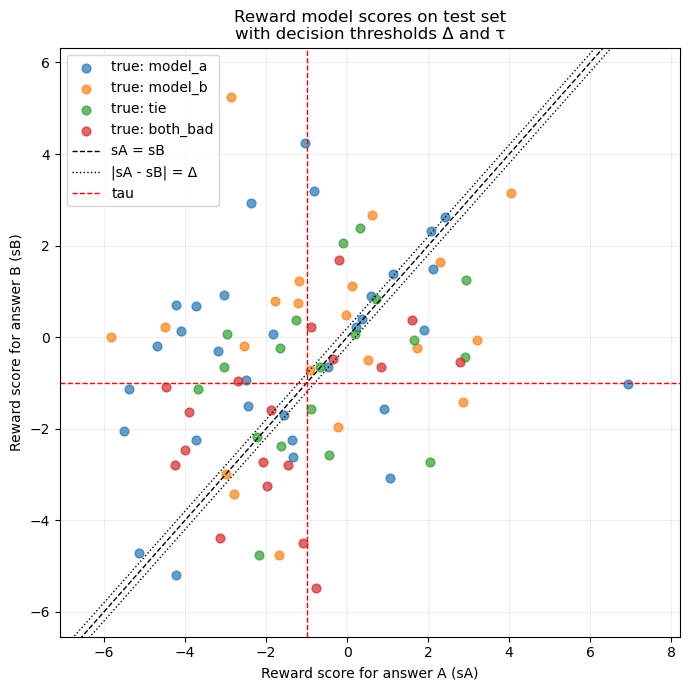

In [19]:
# q = "Solve the equation 3x + 5 = 17."
# aA = "3x + 5 = 17 => 3x = 12 => x = 4. So the answer is 4."
# aB = "3x = 17 + 5 = 22 so x = 22. The answer is 22."

# result = predict_pair_label(q, aA, aB)
# print(result)
# e.g. {'score_a': 1.23, 'score_b': -0.45, 'diff': 1.68, 'label': 'model_a'}

metrics = evaluate_rm_on_test(test_data)